In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
# import login counts json to pandas df
df = pd.read_json("ultimate_challenge/logins.json")
df.index=df['login_time']
df.rename(columns={'login_time':'log_in'}, inplace=True)
df.head()

,log_in
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


In [4]:
# aggregate login counts based on 15-minute time intervals
agg_15 = df.groupby(pd.Grouper(freq='15Min')).size()
agg_15.head()

login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64

In [5]:
# data cleaning checks
agg_15.describe()
# this one 15 min period with 73 logins may be an outlier, but also seems plausible to me

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
dtype: float64

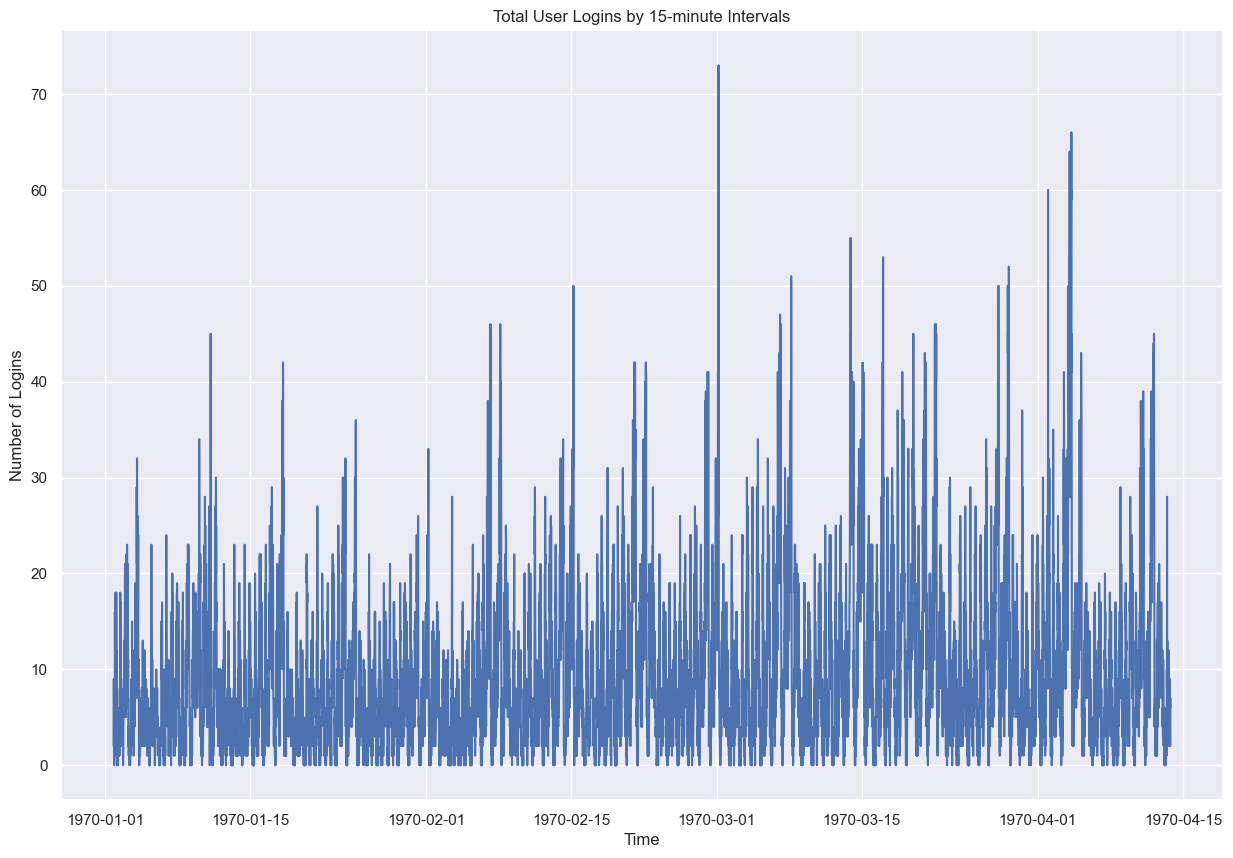

In [6]:
# plot time series of login counts
sns.set_theme(style='darkgrid')
_ = plt.figure(figsize=(15,10))
_ = plt.title("Total User Logins by 15-minute Intervals")
_ = plt.ylabel("Number of Logins")
_ = plt.xlabel("Time")
_ = sns.lineplot(data=agg_15)

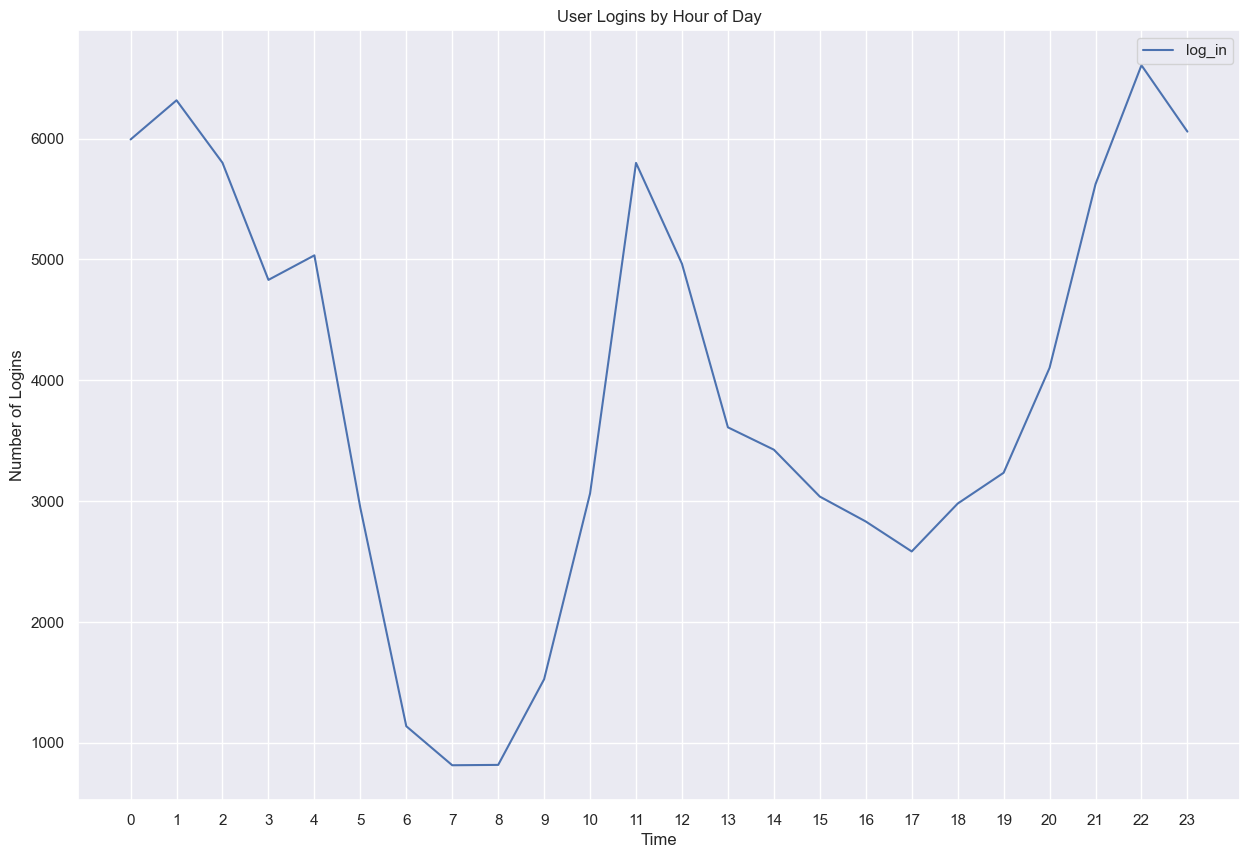

In [7]:
# plot time series of login counts (daily)
df['hour'] = df['log_in'].dt.hour
agg_hour = df.groupby('hour').count()

_ = plt.figure(figsize=(15,10))
_ = plt.title("User Logins by Hour of Day")
_ = plt.ylabel("Number of Logins")
_ = plt.xlabel("Time")
x_ticks = np.arange(24)
_ = plt.xticks(x_ticks)
_ = sns.lineplot(data=agg_hour)

From the plot above, we can see that the peaks for logins occurs at around 11:00 am, 11:00 pm and 1:00 am. The lowest logins occur between 6:00 amd to 8:00 am and again there is a dip around 5:00 pm.

## Part Two: Experiment and Metrics Design

**What would you choose as the key measure of success of the toll reimbursement experiment, and why would you choose this metric?**
When implementing the toll reimbursement experiment, it's crucial to consider various factors. The primary goal is to enhance service reliability, ensuring a sufficient number of drivers are available in close proximity to passengers on both sides of the bridge. Monitoring the average passenger wait time for a driver is essential to gauge the effectiveness of this initiative.

However, the ultimate objective is profitability. If the cost of reimbursing drivers to cross the bridge outweighs the value gained from having more readily available drivers, the initiative may not be financially viable. The profitability projection should extend beyond daily earnings, taking into account the long-term impact on profitability, including a forecast of user churn due to unreliable service.

**Design a practical experiment to compare the effectiveness of the toll reimbursement experiment.**
Experiment Proposal:

a) Initiate communication with a specific subset of drivers, preferably those with high ratings as an indicator of reliability. Notify them that tolls will be reimbursed for each weekend in an upcoming representative month, aiming to capture typical business trends.

b) Evaluate the percentage of drivers from the specified subset who opt to take advantage of the toll reimbursement offer.

c) Assess the change in overall network reliability by measuring the average pickup time.

d) Examine the impact on the overall network profitability, considering factors such as the cost of toll reimbursement, the number of trips, and the total value of trips.

e) Utilize historical data to compare the expense of tolls reimbursed with the added value in terms of increased income for the night (attributed to more efficiently allocated trips) and enhanced service reliability (resulting in reduced user churn).

**Statistical Tests to Verify Significance of Observation**

Verify that the observed reduction in wait time over the four test weekends is not merely a result of random chance by assessing the p-value associated with this outcome. Additionally, examine the p-value for the number of rides provided each weekend night and the average trip cost to ensure that these changes are statistically significant.

**How to Interpret the Results**

Once the p-value analysis indicates a low significance for average pickup time, it suggests that toll reimbursement has likely enhanced service reliability. However, this outcome needs to be translated into its net impact on profitability to assess its overall worth.

Similarly, a low p-value for the number of trips given implies that reimbursing tolls has reduced wait time and decreased passenger cancellations, resulting in more trips. Yet, the key consideration is whether this translates into increased profitability compared to weekends without the program.

If the p-value for average trip cost is low, it is noteworthy and should be interpreted in the context of profitability alongside the other two p-values.

Subsequent Recommendations to the City Operations Team:
If the program proves to be net profitable with the initial subset of drivers, a gradual rollout to lower-rated drivers is recommended. Periodic evaluations of net profitability based on service reliability should be conducted.

Caveats to Recommendations:
Continuing to offer the program on a month-to-month provisional basis is advisable to account for unforeseen consequences in months with potentially different business patterns.

## Part Three: Predictive Modeling
Build a predictive model for user retention (active users defined as having taken a trip in the last 30 days).

In [8]:
# import json as pandas df
df = pd.read_json("ultimate_challenge/ultimate_data_challenge.json")
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [9]:
# find nas
nas=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)/len(df),columns = ['percent'])
pos = nas['percent'] > 0
nas[pos]

,percent
avg_rating_of_driver,0.16244
phone,0.00792
avg_rating_by_driver,0.00402


In [10]:
# determine appropriate replacement values for nas
driver_avg = df['avg_rating_of_driver'].sum()/len(df['avg_rating_of_driver'])
passenger_avg = df['avg_rating_by_driver'].sum()/len(df['avg_rating_by_driver'])
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [11]:
# replace nas
df['avg_rating_of_driver'].fillna(value=driver_avg, inplace=True)
df['phone'].fillna(value='iPhone', inplace=True)
df['avg_rating_by_driver'].fillna(value=passenger_avg, inplace=True)

In [12]:
# convert str dates to dt
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [13]:
# add column for our response variable, drop other cols
df['retained'] = df['last_trip_date'] >= '2014-06-01 00:00:00'
df.drop(columns=['last_trip_date','signup_date'],inplace=True)

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,50000.0,4.480139,0.628662,1.0,4.00,4.70,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,50000.0,4.778081,0.445755,1.0,4.70,5.00,5.00,5.00


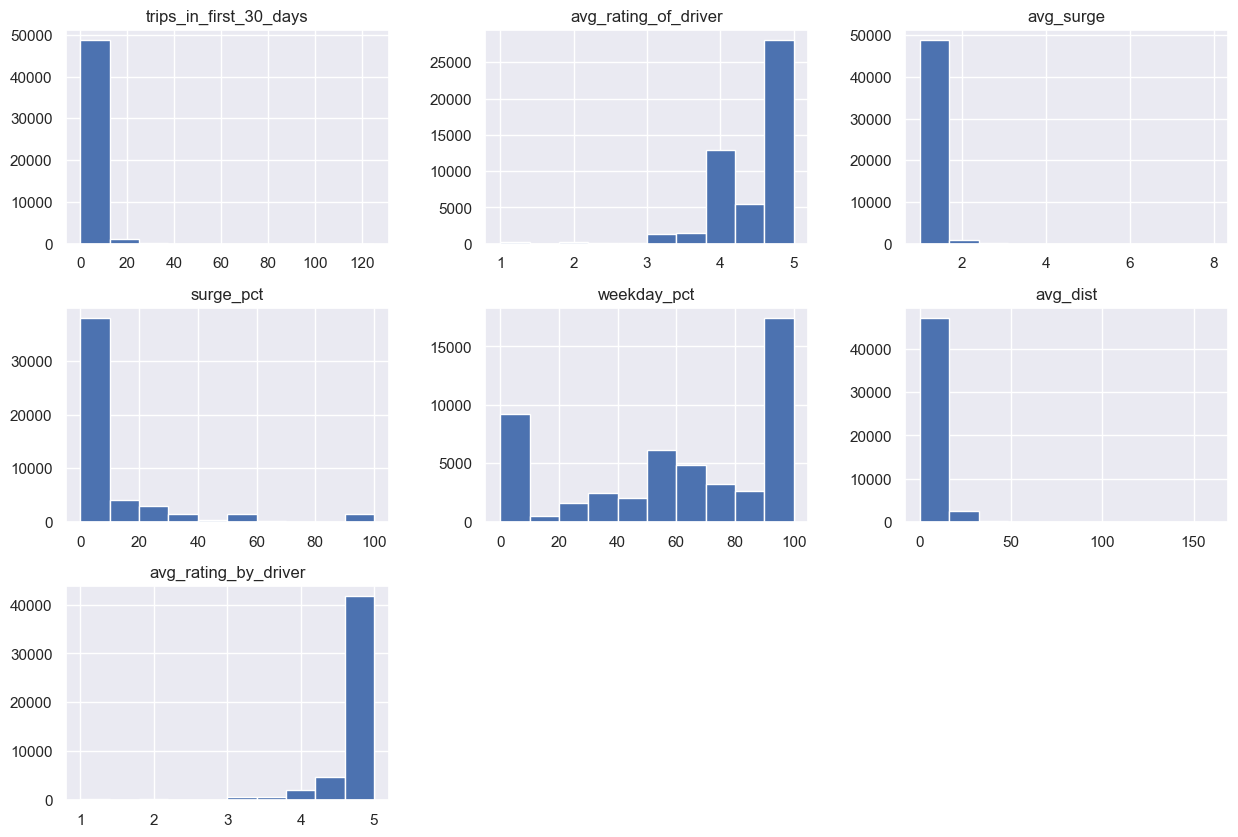

In [15]:
# plot histograms of numerical variables
num_cols = ['trips_in_first_30_days','avg_rating_of_driver','avg_surge','surge_pct','weekday_pct','avg_dist','avg_rating_by_driver']
_ = df[num_cols].hist(bins=10, figsize=(15,10))

In [16]:
# check in on some outliers
df.loc[df['trips_in_first_30_days']>100]
# this one seems to be valid data, although this user took a *lot* of trip in their first 30 days

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
18514,King's Landing,125,5.0,1.12,iPhone,14.4,True,72.0,2.02,4.8,True


In [17]:
# check in on some outliers
df.loc[df['avg_surge']>4]
# these appear to be valid data points--users who signed up, took a high surge trip or two, and then churned

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
1405,Winterfell,1,5.000000,4.75,iPhone,100.0,False,100.0,6.46,5.0,False
2817,Winterfell,0,5.000000,5.00,iPhone,100.0,False,100.0,3.18,5.0,False
5355,Winterfell,1,5.000000,4.25,Android,100.0,False,100.0,0.69,5.0,False
10546,Winterfell,0,3.854082,4.50,iPhone,100.0,False,0.0,2.70,5.0,True
13861,Winterfell,1,1.000000,8.00,iPhone,100.0,False,100.0,5.77,5.0,False
15334,Winterfell,0,3.854082,4.50,iPhone,100.0,False,100.0,1.40,5.0,True
19191,Winterfell,1,5.000000,5.00,Android,100.0,False,100.0,3.37,5.0,False
21742,Winterfell,0,3.854082,4.50,iPhone,100.0,False,0.0,1.42,5.0,True
21894,Winterfell,1,3.854082,5.00,Android,100.0,False,100.0,2.46,4.0,False
25397,Winterfell,0,3.854082,4.25,Android,100.0,False,0.0,3.22,5.0,True


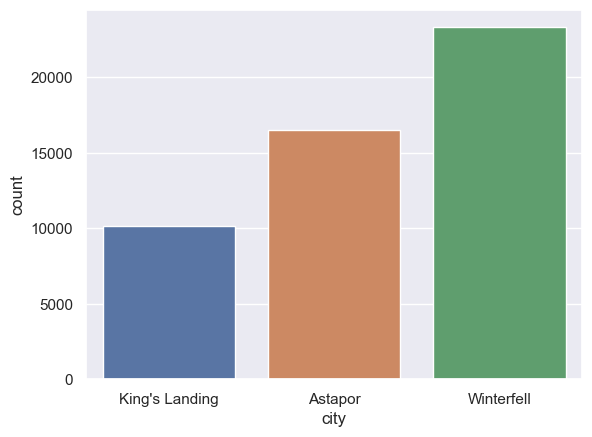

In [18]:
# Categorical Histograms
_ = sns.countplot(data=df, x='city')

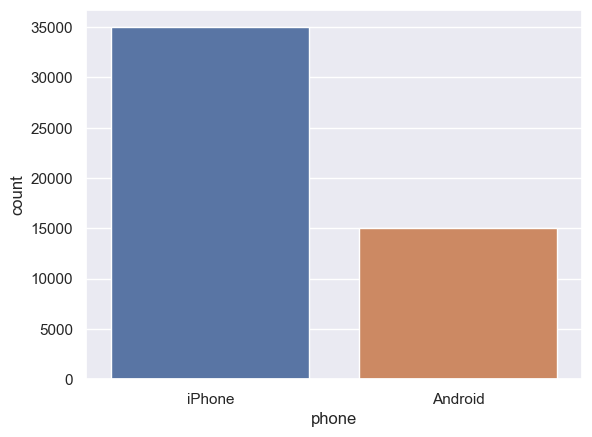

In [19]:
_ = sns.countplot(data=df, x='phone')

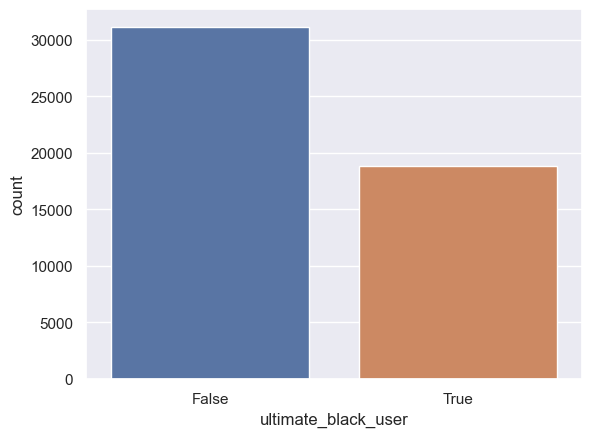

In [20]:
_ = sns.countplot(data=df, x='ultimate_black_user')

In [21]:
# the percentage of observed users who used Ultimate Black in first month
round(df['ultimate_black_user'].mean() * 100,1)

37.7

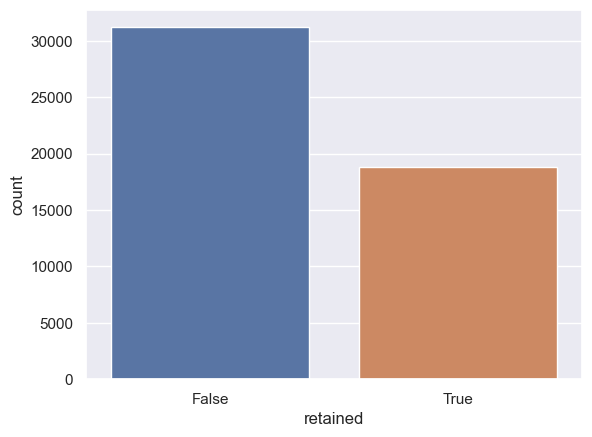

In [22]:
_ = sns.countplot(data=df, x='retained')

In [23]:
# the percentage of observed users who were retained
round(df['retained'].mean() * 100,1)

37.6

In [24]:
# one hot encode categorical variables, drop former labels
df = pd.get_dummies(df,drop_first=True)

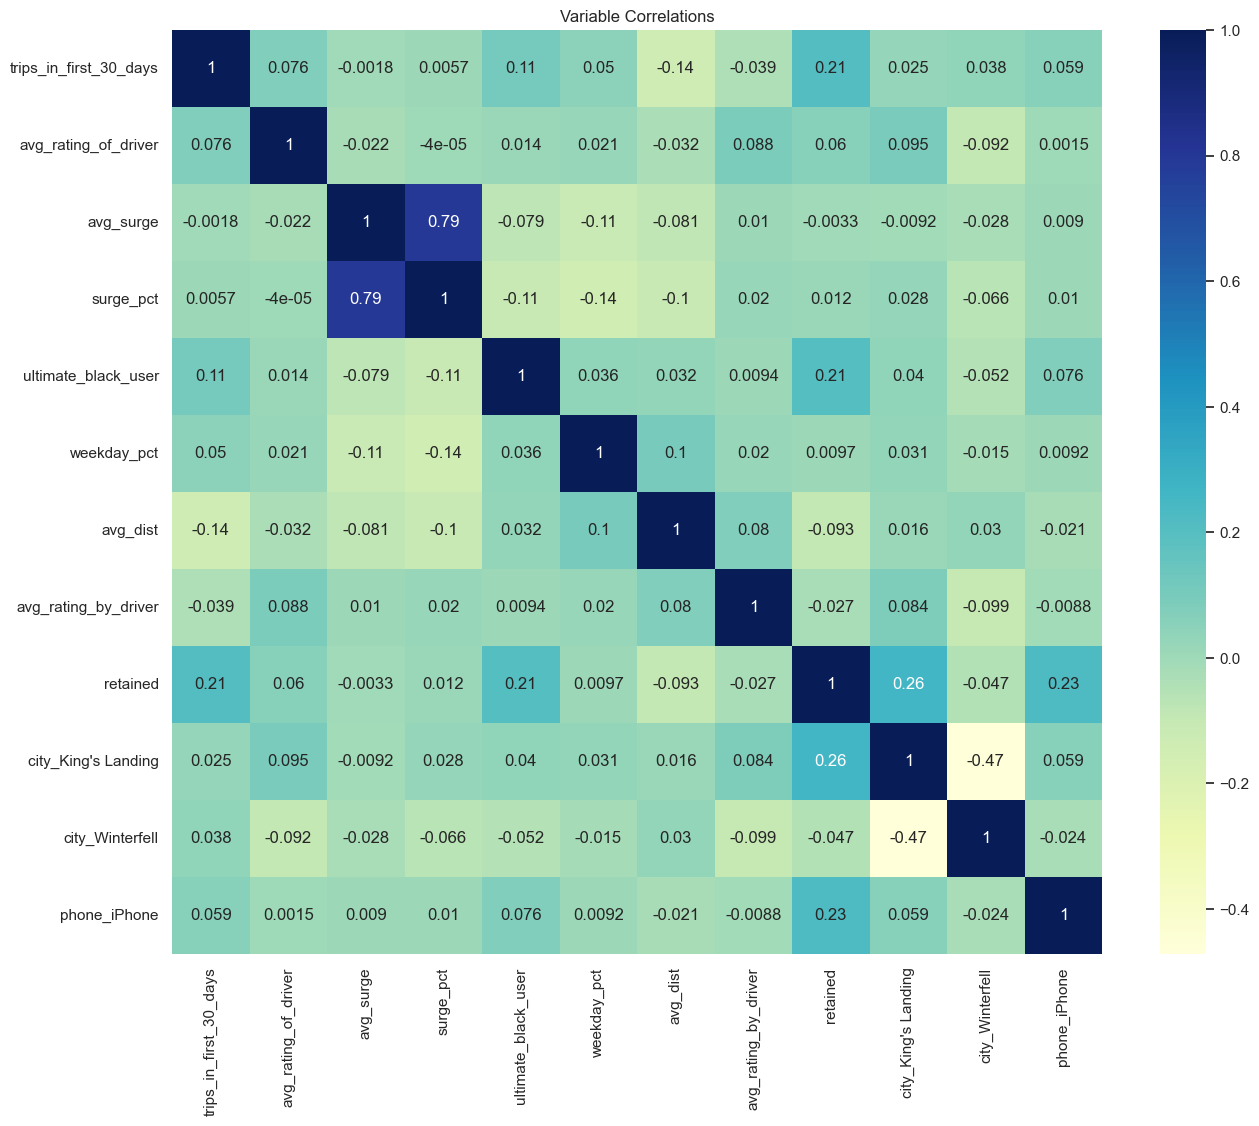

In [25]:
# correlation matrix heatmap
_ = plt.figure(figsize=(15,12))
_ = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
_ = plt.title("Variable Correlations")
plt.show()

In [26]:
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df.drop(["retained"], axis=1)
y = df['retained']
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [27]:
def classifier_suite(X_train,y_train):
    '''Runs through many untuned ensemble classifiers, returns performance metrics as a pd df'''
    from sklearn.svm import LinearSVC, SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
    from xgboost import XGBClassifier
    from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
    import pandas as pd
    import warnings
    warnings.simplefilter('ignore')
    classifiers = [LinearSVC(),SVC(),KNeighborsClassifier(),
                   RandomForestClassifier(),AdaBoostClassifier(),
                   GradientBoostingClassifier(),XGBClassifier()]
    metrics = [roc_auc_score,accuracy_score,f1_score]
    performance = {}
    for clf in classifiers:
        y_pred = clf.fit(X_train,y_train).predict(X_test)
        scores = []
        for metric in metrics:
            scores.append(metric(y_test,y_pred))
        performance[clf] = scores
    
    df = pd.DataFrame(performance,index=["AUROC","Accuracy","F1"])
    df.columns = ['LinearSVC','SVC','KNeighborsClassifier',
              'RandomForestClassifier','AdaBoostClassifier',
              'GradientBoostingClassifier','XGBClassifier']
    return df.T

In [28]:
initial_performance = classifier_suite(X_train,y_train)
initial_performance

,AUROC,Accuracy,F1
LinearSVC,0.665194,0.71344,0.552697
SVC,0.738073,0.77128,0.665026
KNeighborsClassifier,0.720275,0.74368,0.647214
RandomForestClassifier,0.740009,0.75776,0.674549
AdaBoostClassifier,0.757841,0.78280,0.694498
GradientBoostingClassifier,0.761849,0.78616,0.699899
XGBClassifier,0.766132,0.78912,0.705804


Among the models considered, XG Boost demonstrates superior performance out of the box, excelling across all three performance metrics. Consequently, it stands out as the initial choice for predicting user retention. It's worth noting that with further tuning, performance improvements beyond the initial scores can be expected.

The model takes input from various predictor variables, including city, phone type, average distance, average ratings by driver and of driver, surge percentage, average surge, trips in the first 30 days, Ultimate Black user status, and weekday percentage. Using these inputs, it predicts the probability of a user remaining active in their sixth month with an accuracy of slightly over 79%.

Moreover, the model provides insights into feature importance, offering a breakdown of how much each input variable influences the eventual behavior of a user.

In [29]:
# pull features from XGB
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
features = xgb.feature_importances_

In [30]:
feature_importance = pd.DataFrame(zip(df.drop(columns='retained').columns,features))

In [31]:
feature_importance

,0,1
0,trips_in_first_30_days,0.035382
1,avg_rating_of_driver,0.025598
2,avg_surge,0.049809
3,surge_pct,0.052473
4,ultimate_black_user,0.097276
5,weekday_pct,0.063615
6,avg_dist,0.019704
7,avg_rating_by_driver,0.147379
8,city_King's Landing,0.316036
9,city_Winterfell,0.038447


Based on the aforementioned findings, it is evident that factors such as the user's city of residence and the type of phone they use significantly impact the outcomes. Considering this, there may be a need for updates to our Android app to enhance user experience. The feature "Ultimate_black_user" emerges as a crucial element, suggesting the possibility of boosting user retention by offering a discount on Ultimate Black for users during their first month.

Furthermore, a predictive model derived from these insights can be employed to forecast which customers may require additional incentives to remain active, allowing for a targeted approach in allocating resources. These are just initial potential enhancements that such a model could bring to the table.